In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[: 8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)
vocab_size = len(stoi)
vocab_size

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


27

In [4]:
#build dataset
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]  * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[i.item()] for i in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [6]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# ---------------------------------------------------------------------------

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #gain
        self.beta = torch.zeros(dim) #bias
        
        #buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
# ---------------------------------------------------------------------------    
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim = True) #batch mean
            xvar = x.var(dim, keepdim = True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma*xhat + self.beta
            
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
# ---------------------------------------------------------------------------

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []       
# ---------------------------------------------------------------------------

class Embedding:
    def __init__(self, num_embeddings, embeddings_dim):
        self.weight = torch.randn((num_embeddings, embeddings_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
# ---------------------------------------------------------------------------

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n) #// is integer division
        if x.shape[1] == 1:
            x = x.squeeze(1)  #removes the second index
        self.out = x
        return self.out

    def parameters(self):
        return []
# ---------------------------------------------------------------------------

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [7]:
torch.manual_seed(42)

In [8]:
n_embd = 10 #character embedding dimensionality
n_hidden = 68 #number of neurons in hidden layer of MLP 
#hidden layers tuned down to 68 to compare performance with MLP by keeping the total parameters same at 22397

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
])

with torch.no_grad():
    model.layers[-1].weight *= 0.01 #make the last layer less confident for first pass, more equal distribution of probability

parameters = model.parameters()  
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


#Start of Example of how consecutiveflatten is working

In [9]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 13,  9, 12,  9,  1],
        [ 0,  0,  0,  1, 22,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0, 11,  8, 25, 14]])

In [10]:
for layer in model.layers:
    print(layer.__class__.__name__, ':' ,tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [11]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

#End of Example of how consecutiveflatten is working

In [12]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 1.0 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000:3.3080
  10000/ 200000:2.1960
  20000/ 200000:2.4097
  30000/ 200000:2.2101
  40000/ 200000:1.9467
  50000/ 200000:2.3286
  60000/ 200000:2.1721
  70000/ 200000:1.9795
  80000/ 200000:2.1109
  90000/ 200000:2.3020
 100000/ 200000:1.9664
 110000/ 200000:2.6081
 120000/ 200000:2.3451
 130000/ 200000:2.1311
 140000/ 200000:2.3201
 150000/ 200000:1.8742
 160000/ 200000:2.1134
 170000/ 200000:2.2138
 180000/ 200000:2.0950
 190000/ 200000:2.0220


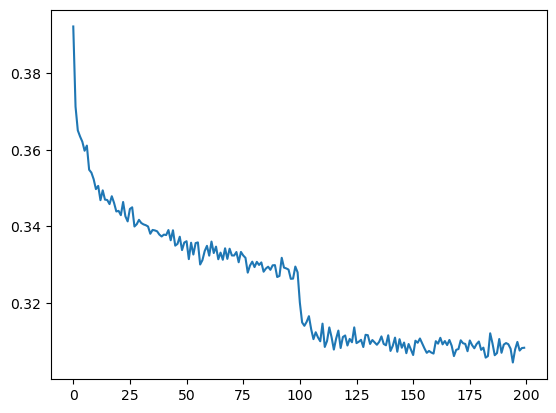

In [13]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
#the sudden drop is the learning rate decay

In [14]:
#put layers into eval mode
for layer in model.layers:
    layer.training = False

In [15]:
@torch.no_grad()  #disables gradient tracking
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 
            'val': (Xdev, Ydev), 
            'test': (Xte, Yte)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0160868167877197
val 2.069270610809326


In [16]:
#sample from the model
g = torch.Generator().manual_seed(9034568)
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

raydyn.
famariel.
kikagofy.
benoletha.
elexten.
elizan.
audleid.
zeyela.
kissa.
rhyana.
